In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import Diagonal
from qiskit.circuit.library import DiagonalGate
from qiskit.circuit.library import MCPhaseGate

import matplotlib.pyplot as plt

import numpy as np

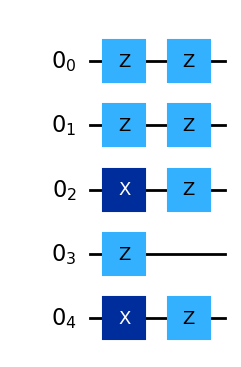

In [7]:
qr = QuantumRegister(5,name='0')
qc = QuantumCircuit(qr,name=f'state_prep')
qc.z(0)
qc.z(1)
qc.x(2)
qc.x(4)

#Z logical = Z
qc.z(qr)

qc.draw(output="mpl")